# Exploratory Graphoid Analysis

> Toward Principled Graphical Model Recovery

## Modeling Edges...as Data?

In [1]:
import networkx as nx
import pandas as pd
from scipy import sparse, linalg, stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import matplotlib as mpl
# mpl.rcParams['font.size'] = 20
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'

def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log2(np.abs(matrix).max()))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

In [2]:
rng = np.random.default_rng(seed=2)

First, let's model a common "social network analysis" task: co-citation networks. 

1. What is our **goal**? 
    > we want to see how authors are "connected" to each other, based on how they write together. 
2. How does our data get created? 
    > Based on how "connected" authors are, they will be more likely to write papers together. Let's say a friendship _causes_ one author to have a higher probability of co-authoring a given paper, if their friend is an author. 
    >
    >We directly observe the resulting indicators (authors co-authored a given paper, for each paper in our dataset). 
3. How is our goal related to our data?
    > Note that we now have an _inverse problem_: what set of friendships would lead to a set of authorships that we observe?

### Synthesize the Data    

Let's directly create a "relaistic" friendship graph.
A reasonable limitation is that people are either pairwise friends or part of a friend "group". 
In other words, if you start with 3 friends, and two of those friends know each other and they both a 4th person, you would also know that 4th person. 

> This is the set of single-vertex-separator graphs, block-graphs, or "clique" unions. 

It happens we can exactly represent the set of block graphs as the line graphs of trees. 
> Both of these classes of graphs are important for the Hammersly-Clifford Theorem, which will become critical, later.

In [3]:
n_authors=20
author_idx = pd.CategoricalIndex((f'author_{i:>02}' for i in range(1,n_authors+1)))

friendships = nx.random_tree(n_authors+1, seed=42) # real events... what "happens" as evidence of a relationship
author_rel = nx.relabel.relabel_nodes(nx.convert_node_labels_to_integers(nx.line_graph(friendships)),dict(zip(range(n_authors),author_idx.categories.tolist())))  # inferred structure
# author_rel.

Text(0.5, 1.0, 'Author Friendships')

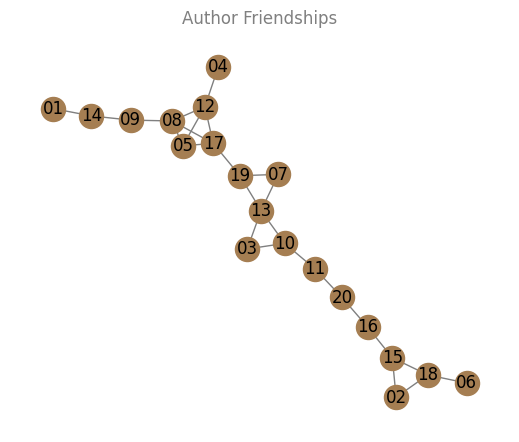

In [4]:
f = plt.figure(figsize=(5,4)).patch.set_alpha(0.)
pos=nx.layout.kamada_kawai_layout(author_rel)
nx.draw(author_rel, pos=pos, 
        node_color='xkcd:puce', edge_color='grey')
nx.draw_networkx_labels(author_rel, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in author_rel})
plt.title('Author Friendships', color='grey')

### What have we observed? 

This is an Incidence Structure, where a friendship is a set (of cardinality 2), and an author is a line. 
Note that the incidence representation of the data is a matrix where the features are 'nodes' and the observations are 'edges'.

In [5]:
# nx.incidence_matrix(author_rel)
incidence = (
    pd.Series.sparse.from_coo(nx.incidence_matrix(author_rel, oriented=True).tocoo())#.set_index(author_idxlevel=0)%%!
    .pipe(lambda df: df.set_axis(df.index.set_levels(author_idx, level=0).swaplevel()))
    .sort_index()
    .astype('Sparse[int]')
)
incidence.head()

# sparse.csc_array.to

/tmp/ipykernel_1685748/2049695675.py:3: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  pd.Series.sparse.from_coo(nx.incidence_matrix(author_rel, oriented=True).tocoo())#.set_index(author_idxlevel=0)%%!


0  author_01   -1
   author_14    1
1  author_02   -1
   author_15    1
2  author_02   -1
dtype: Sparse[int64, 0]

In [6]:
levi=pd.DataFrame({'source':incidence>0}).assign(target=lambda df: ~df.source).assign(exists=lambda df: df.source|df.target)
levi
# levi.source.unstack()-levi.target.unstack()
# levi.exists.unstack()

source  target  exists
0  author_01   False    True    True
   author_14    True   False    True
1  author_02   False    True    True
   author_15    True   False    True
2  author_02   False    True    True
   author_18    True   False    True
3  author_03   False    True    True
   author_13    True   False    True
4  author_03   False    True    True
   author_10    True   False    True
5  author_04   False    True    True
   author_12    True   False    True
6  author_05   False    True    True
   author_12    True   False    True
7  author_05   False    True    True
   author_17    True   False    True
8  author_05   False    True    True
   author_08    True   False    True
9  author_06   False    True    True
   author_18    True   False    True
10 author_07   False    True    True
   author_13    True   False    True
11 author_07   False    True    True
   author_19    True   False    True
12 author_08   False    True    True
   author_09    True   False    True
13 author_08   False    True    True
   author_17    True   False    True
14 author_08   False    True    True
   author_12    True   False    True
15 author_09   False    True    True
   author_14    True   False    True
16 author_10   False    True    True
   author_11    True   False    True
17 author_10   False    True    True
   author_13    True   False    True
18 author_11   False    True    True
   author_20    True   False    True
19 author_12   False    True    True
   author_17    True   False    True
20 author_13   False    True    True
   author_19    True   False    True
21 author_15   False    True    True
   author_16    True   False    True
22 author_15   False    True    True
   author_18    True   False    True
23 author_16   False    True    True
   author_20    True   False    True
24 author_17   False    True    True
   author_19    True   False    True

In [7]:
B = incidence.unstack().fillna(0.)
B.head()

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is different from the adjacency representation, where the sparse representation comes from an "edgelist" view:

In [8]:
edgelist = (
    nx.to_pandas_edgelist(author_rel)
    .astype(dict(source=author_idx.dtype, target=author_idx.dtype))
)
edgelist.head()

,source,target
0,author_01,author_14
1,author_02,author_15
2,author_02,author_18
3,author_03,author_13
4,author_03,author_10


However, the two are _related_. 

The Laplacian is defined as the grammian of the _oriented_ incidence matrix:

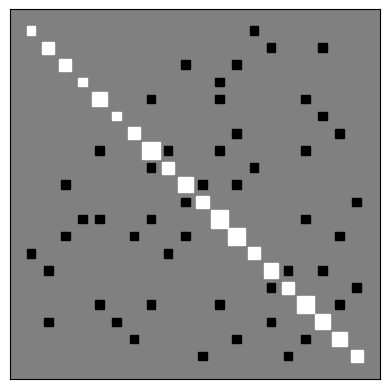

In [9]:
L = B.T@B
# L = incidence.sparse.to_coo()[0].T@incidence.sparse.to_coo()[0]
# sns.heatmap(L, mask=L==0)
hinton(L.values)

### Hang on, the Grammian? That sounds familiar...

Indeed, from an edge-observational point of vieew, the Laplacian would just be the unscaled scatter matrix of our sample data: 

$$S = \frac{1}{N-1} X^TX = \frac{1}{N-1}L$$

In turn, our data covariance would be the _centered_ version of our data. 
> NOTE that for _undirected graphs_, we are implicitly observing two copies of each "oriented edge" (one for each direction). So, we can easily show that the centered data matrix
> $$B_c = \begin{bmatrix} B \\-B\end{bmatrix}$$
> should have exactly $L_c = 2 L = (N-1)\frac{1}{2}S$

Thus undirected Laplacians are the unscaled covariance matrices of our edge observations, and we can be on our merry way using graphs and their laplacians to analyze our social network...right?

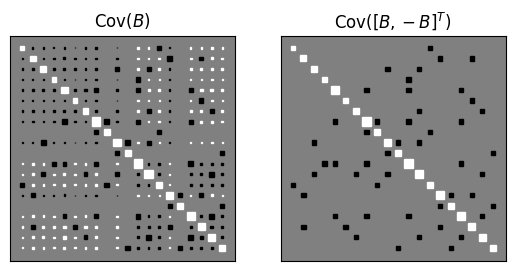

In [10]:
f,ax=plt.subplots(ncols=2)# M = np.abs(B).cov()
hinton(B.cov().values, ax=ax[0])
ax[0].set(title=r'$\mathrm{Cov}(B)$')
# ax[1].set(title=r'$\mathrm{Cov}\begin{bmatrix} B \\-B\end{bmatrix}$')
ax[1].set(title=r'$\mathrm{Cov}([B,-B]^T)$')

M = pd.concat([B, -B]).cov()
# sns.heatmap(M, mask=M==0)
hinton(M.values, ax=ax[1])

### Some problems: what's in an edge? 

The Laplacian is typically used as a continuous-time analog for dynamic systems. 
For instance, it's the discrete _Laplace Operator_, a green's function for discrete Poisson equation: 
$$\frac{d x}{d t} = -kLx$$

It's also called the _Kirchoff Matrix_, due to its relation with the flow of current in an electrical network. It encodes the flow of energy from each node to the nodes it is connected to. 
> This explains the "oriented" part! Every edge means a unit of energy can flow "from" one node "to" another, according to the conductance between them!

But.... This has some major implications for our original model. Remember: 
> we want to connect authors if they have a friendship that corresponds to increased conditional probability of co-authorship. 

Nothing is "flowing". Our observation of authorship doesn't take away some amount of authorship from their friend at some subsequent timestep. 

> These kinds of issues are _everywhere_ in network analysis... ask yourself: **what do our edges measure?**

Instead of a friendship implying _negative correlation_ (see the negatives in all off-diagonals in $L$?), we probably want our friendships to indicate positive correlations. 

Do this by using the unsigned laplacian $L_S$, which we can get from the _unoriented_ incidence matrix.

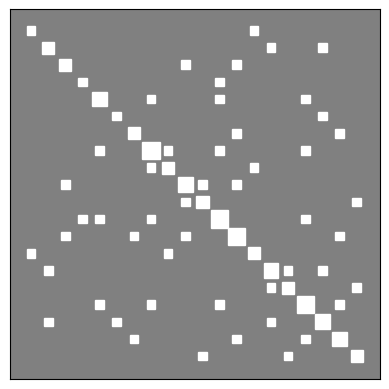

In [11]:
Ls = np.abs(B).T@np.abs(B)  # signless Laplacian
# sns.heatmap(Ls, mask=Ls==0)
hinton(Ls.values)
# sns.heatmap(np.linalg.inv(Ls), mask=np.abs(np.linalg.inv(Ls))<=0.1)
# sns.heatmap(np.linalg.pinv(2*L/(B.shape[0]-1)))
# sns.heatmap(np.linalg.inv(np.eye(n_authors)+0.05*L).dot(L))

Better, but recall that for our statistical modeling desires, empirical covariance must be centered (which only _happend_ to work out for us in the _oriented_ case. 

What does our graphical scatter look like now?

Something is weird. 

There are negative values? 
Folks that weren't friends are now friends, and folks that didnt know each other at all... kinda oppose each other? 

> If you're not with me... _you're my enemy_. 

(Thanks a lot, ~~Anakin~~Darth Vader)

Indeed, the sample covariance matrix is a _biased_ intrinsic estimator. 
Estimating the true covariance from data is the problem of _Covariance Estimation_, which usually involves sparsity constraints and optimization of the determinant (Graphical Lasso).

This is all _before we've even gotten to our actual observational model_, which will further obscure what exactlyshould and should not be real edges. 

Remember, what we want to _recover_ is a graph like the one at the top, where we see "real" friendships. even if our data is a set of observations of _only friends, exclusively, co-authoring a single paper per mutual friendship_, we would still be way off in determining friendships due to the bias inherent in the signless laplacian, and the normal laplacian is not at all going to model what we are after in the first place. 

> We need to recover the true covariance struture with better techniques than the co-occurrence laplacian, even if our data is _perfect_. 

And, trust me, it most certainly is _not_.

True

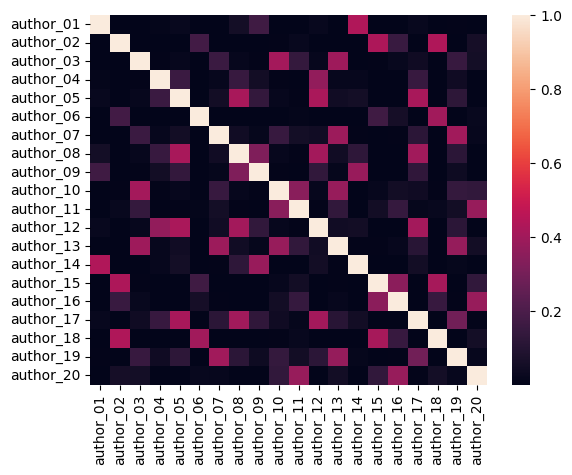

In [12]:
def forest(L, β=1):
    return pd.DataFrame(np.linalg.inv(np.eye(L.shape[0])+β*L), columns=L.columns, index=L.index)

def interp_dist(L, β=1):
    Q = forest(L, β)
    norm = np.sqrt(np.multiply.outer(q_ii:=np.diag(Q), q_ii))
    return -np.log(Q/norm)

def symm_norm(L, d=None):
    if d is None: 
        d = 1./np.sqrt(np.diag(L))
    return np.diag(d)@L@np.diag(d)

sns.heatmap(np.exp(-interp_dist(L)))

np.allclose(np.linalg.inv(symm_norm(L+np.eye(n_authors), d=np.sqrt(np.diag(forest(L))))),np.exp(-interp_dist(L)))

## Modeling Observation Data as...Edges?

Let's use our gaussian probabilistic graphical model (it's a Markov Random Field) to generate some fake data. 
For each week in the next, say, 1 or so years, let's ask our set of vaugely-associated authors whether the wrote a paper or not.

In [13]:
cov = stats.Covariance.from_precision(symm_norm(L+np.eye(n_authors), d=np.sqrt(np.diag(forest(L)))))

papers = pd.DataFrame(
    np.where(stats.multivariate_normal(np.zeros(n_authors),cov=cov).rvs(100)>0.6, 1,0),
    columns=author_idx
).rename_axis(index='week', columns='author')
papers.melt(ignore_index=False, var_name='author').replace(0,np.nan).dropna().reset_index().set_index(['week', 'author']).sort_index()

value
week author          
0    author_02    1.0
     author_04    1.0
     author_06    1.0
     author_07    1.0
     author_16    1.0
...               ...
98   author_04    1.0
     author_14    1.0
     author_16    1.0
99   author_10    1.0
     author_17    1.0

[519 rows x 1 columns]

In [14]:
def incidence_to_levi(df):
    # return (
    #     df                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    #     .melt(ignore_index=False, var_name=df.columns.name)
    #     .replace(0,np.nan)
    #     .dropna()
    #     .reset_index()
    #     .astype({df.index.name:df.index.dtype, df.columns.name:df.columns.dtype})
    #     .set_index([df.index.name, df.columns.name]).sort_index()
    # )
    
    
    X = sparse.coo_array(papers.values)#papers.astype('Sparse[int]').sparse.to_coo()
    return pd.Series(X.data, 
                     index=pd.MultiIndex.from_arrays(
                         [df.index[X.row], df.columns[X.col]],
                         names=[df.index.name, df.columns.name]
                     ),#.astype(df.index.dtype, df.columns.dtype), 
                     dtype=pd.SparseDtype(int, fill_value=0))#.sort_index()
incidence_to_levi(papers).unstack(fill_value=0.)#.dtypes

# levi[S,V,O]
# edgelist[S,V,O]
# def adjacency_to_edgelist(df):
#     ...
# edgelist_to_adjacency==edgelist.unstack
# adjacency_to_edgelist(edgelist).unstack()

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
week,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
96,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0


Text(0.5, 1.0, 'co-occurrence counts')

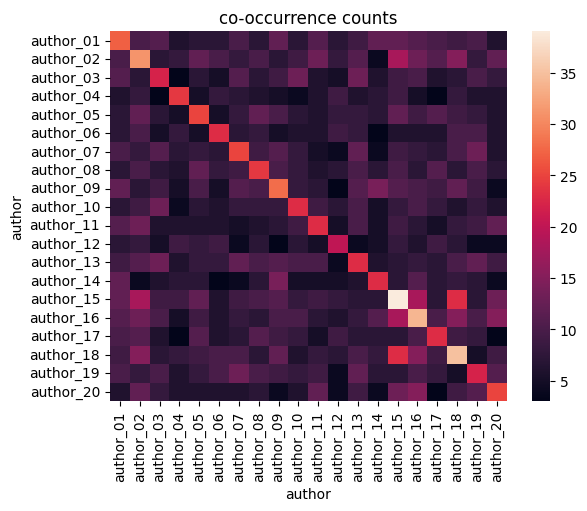

In [15]:
# Scatter Matrix
sns.heatmap(papers.T@papers)
plt.title('co-occurrence counts')

Ok, what's going on...??

Recall that, before, we counted edges as observations. 
Edges were indeed in the node-feature-space $\mathbb{R}^n$, but they only ever had a source and a target (marginal sum was 2). 
Now we are allowing much bigger "edges". 

In fact, this observational data is still an incidence structure, but it is a _hypergraph_. 
Hypergraphs have 1-to-1 corresponcence with _bipartite graphs_, and the _biadjacency_ matrix is the matrix we just saw.
By taking the _inner product_ of all pairs of edges in this bipartite graph, we have now performed what's called a _linear bipartite projection_ of the hypergraph into a graph on only authors. 

Linear projections make the (rather presumptuous) assertion that all hyperedges/sets are equivalent to linear combinations of their subsets --- specifically, a union of all pairwise relations.

In [16]:
obs_incidence = (
    papers.melt(ignore_index=False, var_name='author')
    .reset_index()
    .astype({'author':author_idx.dtype, 'value':'Sparse[int]'})
    .set_index(['week','author'])
)['value']

obs_incidence

week  author   
0     author_01    0
1     author_01    0
2     author_01    1
3     author_01    0
4     author_01    0
                  ..
95    author_20    1
96    author_20    0
97    author_20    0
98    author_20    0
99    author_20    0
Name: value, Length: 2000, dtype: Sparse[int64, 0]

Text(0.5, 0.98, 'Authors on a paper, week X')

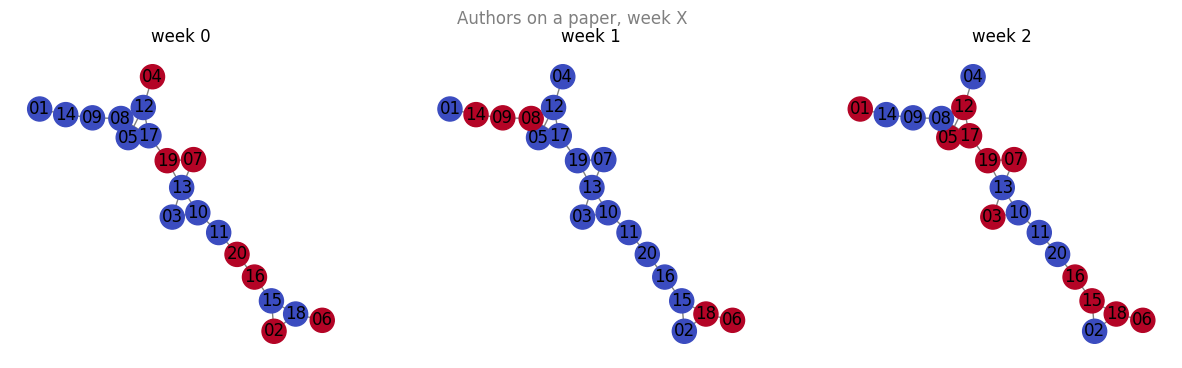

In [17]:
f, axs=plt.subplots(ncols=3, figsize=(15,4)) 
f.patch.set_alpha(0.)
for n,ax in enumerate(axs): 
    nx.draw(author_rel, pos=pos, edge_color='grey',
        node_color=obs_incidence[n].loc[list(author_rel.nodes)], cmap='coolwarm', ax=ax)
    nx.draw_networkx_labels(author_rel, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in author_rel}, ax=ax)
    ax.set(title=f'week {n}')
f.suptitle('Authors on a paper, week X', color='grey')

Text(0.5, 1.0, 'co-occurrence counts')

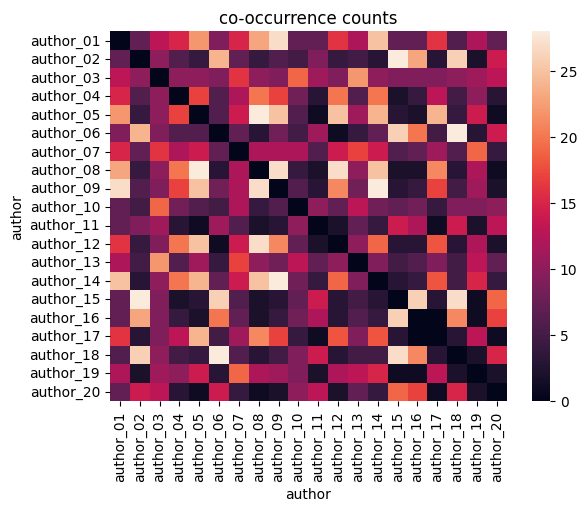

In [17]:
sns.heatmap(obs_incidence.unstack().T@obs_incidence.unstack() - np.diag(obs_incidence.unstack().sum()))
plt.title('co-occurrence counts')

Text(0.5, 1.0, 'covariance')

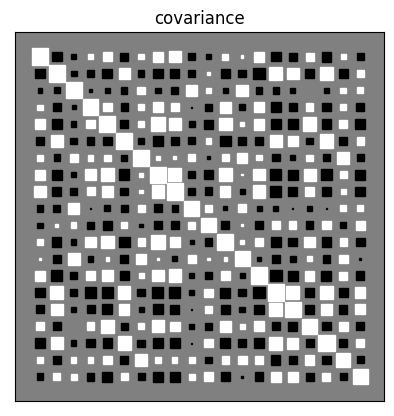

In [18]:
# sns.heatmap(obs_incidence.unstack().cov())
hinton(obs_incidence.unstack().cov().values)
plt.title('covariance')

Co-Occurrence Covariance and our "unrolled" edges' grammian: the two are _the same_

In [19]:
(papers.cov()-obs_incidence.unstack().cov()) # to machine precisio

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
#.div(papers.sum(axis=1), axis='rows').pipe(lambda df: 10*df/(1-df))
(papers.T@(1-papers))*((1-papers).T@papers)
(1-papers).T@(1-papers)#*(papers.T@papers)

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author,,,,,,,,,,,,,,,,,,,,
author_01,78,51,57,48,53,58,62,53,59,56,52,51,60,59,57,58,49,53,61,58
author_02,51,63,49,43,45,47,46,44,47,46,45,43,50,44,52,51,41,47,49,51
author_03,57,49,71,47,50,49,61,48,51,56,52,45,60,50,57,56,44,47,58,56
author_04,48,43,47,67,51,49,51,51,48,48,46,54,53,43,49,48,45,45,56,50
author_05,53,45,50,51,69,50,51,50,49,50,51,50,51,51,50,50,46,44,56,52
author_06,58,47,49,49,50,73,55,51,52,54,49,45,59,51,59,53,44,58,59,53
author_07,62,46,61,51,51,55,77,53,53,61,54,52,64,49,59,59,49,48,66,60
author_08,53,44,48,51,50,51,53,69,54,48,50,52,54,52,52,48,48,47,56,53
author_09,59,47,51,48,49,52,53,54,72,51,49,49,53,54,53,51,43,51,56,51


In [124]:
# np.outer(np.diag(papers.T@papers),np.diag(papers.T@papers))-papers.T@papers

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author,,,,,,,,,,,,,,,,,,,,
author_01,462,804,630,723,676,587,499,676,607,610,677,741,501,691,546,545,827,697,437,566
author_02,804,1332,1058,1208,1134,988,845,1135,1024,1025,1134,1244,841,1171,911,912,1390,1168,734,948
author_03,630,1058,812,948,889,778,654,891,804,799,887,978,655,917,714,715,1091,920,573,743
author_04,723,1208,948,1056,1008,882,752,1008,915,915,1013,1101,750,1048,818,819,1238,1046,651,849
author_05,676,1134,889,1008,930,829,708,949,860,859,948,1039,708,978,769,769,1163,985,613,797
author_06,587,988,778,882,829,702,616,828,749,747,830,912,612,854,664,670,1017,847,534,696
author_07,499,845,654,752,708,616,506,706,640,632,705,773,519,732,568,568,864,733,451,589
author_08,676,1135,891,1008,949,828,706,930,855,861,949,1037,705,977,767,771,1161,982,613,796
author_09,607,1024,804,915,860,749,640,855,756,777,860,941,640,882,694,696,1055,885,556,723


### An Aside: Modeling Complex Systems --- Torres et al (2021)

A more precise description of what's going on here is that our observations _are_ hyperedges. 
However, to simply calculate an empirical covariance (which is a centered/scaled version of the co-occurrence Laplacian), whe are implicitly forming a downward-closure of our hyperedges, turning them into **$k$-simplices**.

Now recall that a hyperedge (publication, in our data) with $k$ authors being turned into a $k$-simplex makes it identical to another simplex on the same authors. 
Think of this as "forgetting" that documents are independent observations of relationships in the hyperedge. 
The inner product will treat any co-occurrence in any document as equivalent to another co-occurrence anywhere else. 

> We have implicitly removed conditional independence from our model

Then, to get to a graph again, we assume that each inner-product can stand in for its own, pairwise relationship... its own edge weight. 
So, it's impossible to tell if a given projected edge came about because of participation in one _huge_ paper, a bunch of smaller papers, or maybe a mixture. 
This is implied by the inner product itself, due to associativity of addition/multiplication. 

> We have implicitly removed higher-order interractions from our model

### I'm Lost in the weeds

One way of building intuition on this is to ask yourself: Is it more likely, given a paper's list of authors ...?
> for all authors to have been equally friends with every other author, a priori

or

> for authors to have been asked by a single friend, with the ability to ask one other friend. 

Both are probably a _stretch_, with respect to how papers are really going to get written (there's probably a lot more drama!). 
But it should be clear that, as we move away from the $n=2$ case (where the two options are equivalent), to higher numbers of co-authors, the situation where you know everyone else equally _under our conditional probability definition of friendship_ becomes far more unlikely that not.

### Sounds good, but _why_?
Why is it less likely? 
After all, isn't a model where every pair is assigned equal probability an... uninformative prior, of sorts? There's fewer decisions I, as an analyst must make (read: fewer parameters), so shouldn't the complexity be lower, somehow? 

It depends on your prior, much like our deference to sparse models (even if they need tuning). 
If we believe a priori that, say, any two authors in the set are some probability $p<1$ to be friends, then the chance of observing the mutual friendship of $k$ authors is distributed as a binomial distribution on ${k \choose 2}$ trials (one for each edge).  

Even if every author has equal odds of knowing any other author (which should ring massive alarms, given our block-graph model of the world), then the prior likelihood of a clique should be

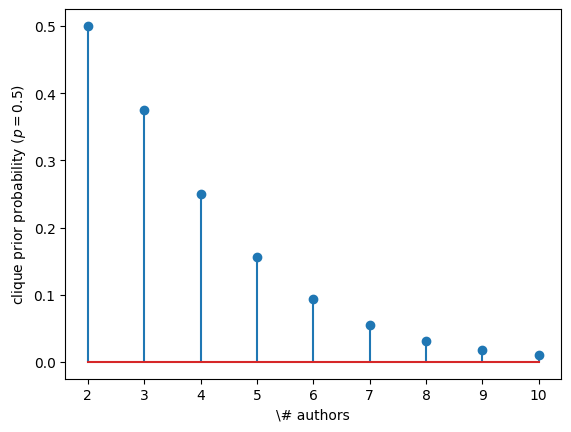

In [20]:
from scipy.stats import binom
plt.stem(x:=np.arange(2,11), binom.pmf(1., x,0.5))#.pmf(np.arange(10))
plt.gca().set(xlabel='\# authors', ylabel='clique prior probability ($p=0.5$)');

In reality $p$ should be a lot lower, and _certainly_ infuenced by our domain knowledge.

Text(0.5, 1.0, 'covariance')

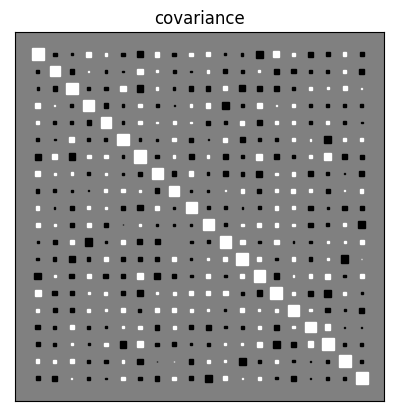

In [32]:
# Now the Covariance
# sns.heatmap(papers.cov())
hinton(np.linalg.pinv(papers.cov().values))
plt.title('covariance')

<AxesSubplot: >

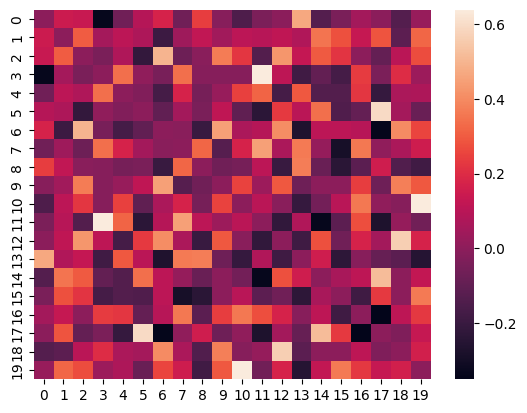

In [33]:
from scipy.stats import kendalltau
from scipy.spatial.distance import cdist, pdist, squareform

sns.heatmap(np.sin(np.pi*0.5*squareform(pdist(papers.values.T, metric=lambda x,y: kendalltau(x,y)[0]))))

<AxesSubplot: >

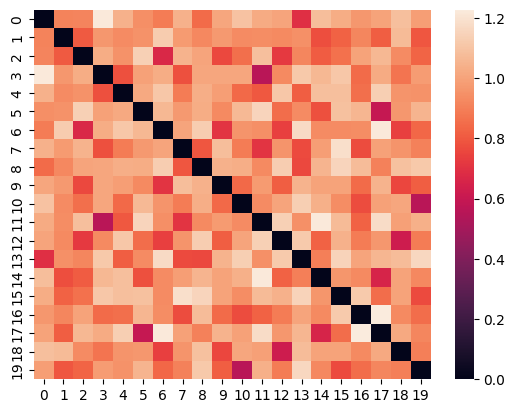

In [34]:
sns.heatmap(squareform(pdist(papers.T, metric='correlation')))

In [35]:
dists=pd.melt(interp_dist(L), ignore_index=False, var_name='target').rename_axis('source').reset_index().set_index(['source','target'])
# (pd.DataFrame(np.minimum.outer(dists.values.T[0], dists.values.T[0]), index=dists.index, columns=dists.index)>dists.values@np.ones_like(dists).T).sum()
# np.less.outer(
#     pd.DataFrame(np.minimum.outer(dists.values.T[0], dists.values.T[0]), index=dists.index, columns=dists.index),
#     dists.values.T[0]
# )#.sum()
pd.DataFrame(np.minimum.outer(dists.values.T[0], dists.values.T[0]), index=dists.index, columns=dists.index).loc['author_01', 'author_02']

source     target   
author_01  author_01    -0.000000
author_02  author_01    11.961553
author_03  author_01     7.005282
author_04  author_01     4.841051
author_05  author_01     3.804816
                          ...    
author_16  author_20     0.975623
author_17  author_20     5.245597
author_18  author_20     2.906985
author_19  author_20     4.006449
author_20  author_20    -0.000000
Name: (author_01, author_02), Length: 400, dtype: float64

In [36]:
dists=pd.melt(interp_dist(np.diag((papers.T@papers-np.diag(papers.sum())).sum()) - (papers.T@papers - np.diag(papers.sum()))), ignore_index=False, var_name='target').rename_axis('source').reset_index().set_index(['source','target'])
np.less.outer(
    pd.DataFrame(np.minimum.outer(dists.values.T[0], dists.values.T[0]), index=dists.index, columns=dists.index),
    dists.values.T[0]
).sum()
# dists.values@np.ones_like(dists).T

/tmp/ipykernel_195019/2309541422.py:2: FutureWarning: outer method for ufunc <ufunc 'less'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the DataFrame to an array with '.to_numpy()' first.
  np.less.outer(


42415412

<AxesSubplot: >

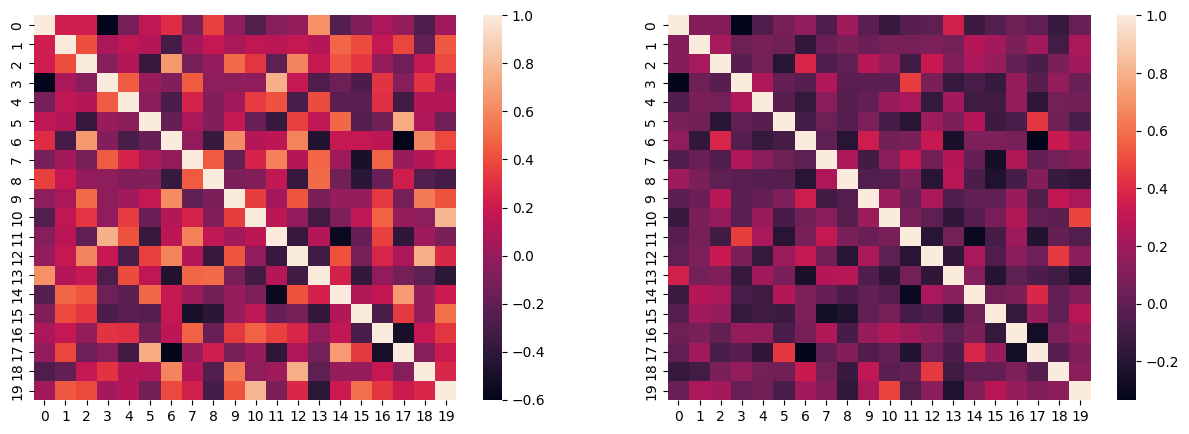

In [44]:
def binary_semirank_tau(x,y):
    n = x.shape[0]
    x_diff, y_diff = np.subtract.outer(x,x),np.subtract.outer(y,y)
    return np.sum(x_diff*y_diff)/(n*(n-2))

def binary_rank_tau(X):
    nsamp=X.shape[0]
    tri_row, tri_col = np.tril_indices(nsamp, k=0)
    diff = X[tri_row] - X[tri_col]
    
    norm_factor=2/(nsamp*(nsamp-1))
    cooc = norm_factor*diff.T@diff
    return cooc-np.diag(np.diag(cooc))+np.eye(X.shape[1])

def binary_sample_cdf(df):
    return df.cov() + np.multiply.outer(μ:=df.mean().values,μ)

squareform(pdist(papers.values.T, metric=binary_semirank_tau)) #- papers.cov() +np.outer(papers.mean().values, papers.mean().values)
# squareform(pdist(papers.values.T, metric='yule')) #- papers.cov() +np.outer(papers.mean().values, papers.mean().values)
A_samp =  ((papers.T@papers) - np.diag(papers.sum()))
L_samp = np.diag(A_samp.sum()) - A_samp

def binary_contingency(X):
    n = X.shape[0]
    both = X.T@X/n#np.multiply.outer(X, X).mean(axis=2).mean(axis=0)
    neither = (1-X).T@(1-X)/n#np.multiply.outer(~X, ~X).mean(axis=2).mean(axis=0)
    one = X.T@(1-X)/n#np.logical_and.outer(X, ~X).mean(axis=2).mean(axis=0)
    other = one.T
    return neither, one, other, both

def odds_ratio(X):
    a,b,c,d = binary_contingency(X)
    return a*d/(b*c)
    
    # return both*neither/(one*other)
def yule_y(X):
    a,b,c,d = binary_contingency(X)
    return ((ad:=np.sqrt(a*d))-(bc:=np.sqrt(b*c)))/(ad+bc)
    # return ((sor:=np.sqrt(OR))-1)/(sor+1)
    # return ((ad:=np.sqrt(both*neither))-(bc:=np.sqrt(one*other)))/(ad+bc)
    
def yule_q(X):
    a,b,c,d = binary_contingency(X)
    return ((ad:=a*d)-(bc:=b*c))/(ad+bc)
f,ax = plt.subplots(ncols=2, figsize=(15,5))
# sns.heatmap(np.corrcoef(papers.values, rowvar=False), ax=ax[0])
# sns.heatmap(np.exp(-interp_dist(L_samp, β=0.1)), ax=ax[0])
# sns.heatmap(squareform(pdist(papers.values.T, metric=binary_semirank_tau)), ax=ax[0])
# sns.heatmap(np.exp(-0.1*interp_dist(L)), ax=ax[0])
sns.heatmap(yule_y(papers.values), ax=ax[1])
sns.heatmap(yule_q(papers.values), ax=ax[0])

    # one = np.logical_xor
# papers.cov()
#  ==
# papers.T@(1-papers)/papers.shape[0]
# (1-papers).T@(1-papers)/papers.shape[0]
# ((~papers).T@(~papers))
# np.allclose(np.multiply.outer(papers.values, papers.values).mean(axis=2).mean(axis=0), np.logical_and.outer(papers.astype(bool).values, papers.astype(bool).values).mean(axis=2).mean(axis=0))

<AxesSubplot: ylabel='Density'>

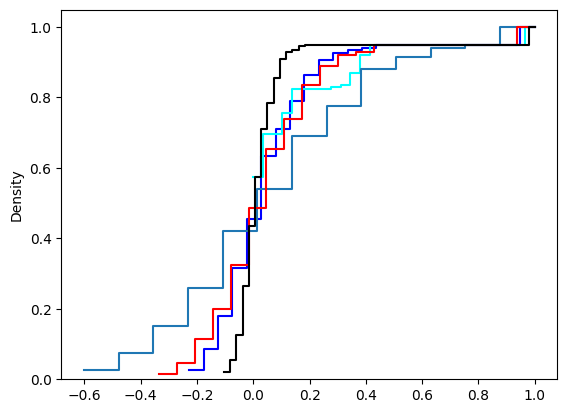

In [45]:
sns.histplot(np.corrcoef(papers.values, rowvar=False).flatten(), color='b', fill=False, stat='density', element='step', cumulative=True)
sns.histplot(np.exp(-1*interp_dist(L, β=1).values).flatten(), color='cyan', fill=False, stat='density', element='step', cumulative=True)
sns.histplot(yule_q(papers.values).flatten(), fill=False, stat='density', element='step', cumulative=True)
sns.histplot(yule_y(papers.values).flatten(), color='r', fill=False, stat='density', element='step', cumulative=True)
sns.histplot(binary_rank_tau(papers.values).flatten(), color='k', fill=False, stat='density', element='step', cumulative=True)

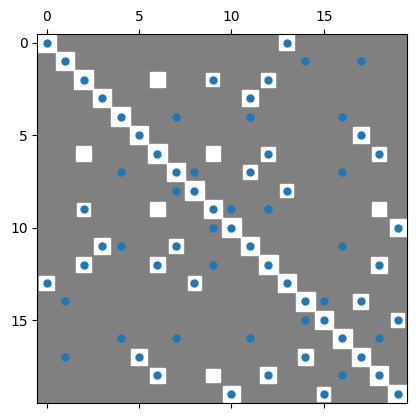

In [49]:
hinton((lambda a: np.where(a>0.5, a,0))(yule_q(papers.values)))
plt.spy(L, marker='.')

In [65]:
papers.cov().values+np.multiply.outer(papers.mean().values, papers.mean().values)
stats.norm.ppf(1-papers.mean())[np.tril_indices(n_authors)[0]]

def pairwise(x, k=0):
    """for length n, return k=n(n-2)/2 pairwise combinations in a (k,2) array"""
    tri_row, tri_col = np.tril_indices(x.shape[0], k=k)
    return np.vstack((x[tri_row], x[tri_col])).T
pairwise(stats.norm.ppf(1-papers.mean()))

def flatten_pairwise(A, k=0):
    tri_idx=np.tril_indices(A.shape[0], k=k, m=A.shape[1])
    return A[tri_idx]



np.kron( np.arange(1,5)[:,None], np.eye(2)).reshape(4,2,2)

def bivn_corr(p):
    return p*np.ones((2,2))-np.eye(2)*(p-1)
# 5*np.ones((2,2))-np.eye(2)*(5-1)

    # stats.norm.ppf(1-papers.mean())[np.tril_indices(n_authors)[0]]
stats.multivariate_normal.cdf(pairwise(stats.norm.ppf(1-papers.mean()))[0], cov=bivn_corr(0.1))   
# pairwise(stats.norm.ppf(1-papers.mean()))
def F(d,r):
    return 2*(stats.multivariate_normal.cdf(d, cov=bivn_corr(r), allow_singular=True) -\
              stats.norm.cdf(d[0])*stats.norm.cdf(d[1]))

# from functools import partial
def obj_func(d, r_obs):
    return lambda r: np.abs(F(d,r) - r_obs)

from scipy.optimize import root_scalar, minimize_scalar

minimize_scalar(obj_func(pairwise(stats.norm.ppf(1-papers.mean()))[7], flatten_pairwise(binary_rank_tau(papers.values))[1]), bounds=(-0.99,0.99))

# for i in np.linspace(-1.0,1.):
#     print(F(pairwise(stats.norm.ppf(1-papers.mean()))[2], i)-flatten_pairwise(binary_rank_tau(papers.values))[2])

res=squareform([minimize_scalar(
    obj_func(pairwise(stats.norm.ppf(1-papers.mean()))[i], flatten_pairwise(binary_rank_tau(papers.values))[i]), 
    bounds=(-0.99,0.99)
).get('x') for i in range((n_authors**2-n_authors)//2)
])

# stats.norm.ppf(1-papers.mean())#[np.array([0,1])]


    # (papers.values.T[np.tril_indices(n_authors)[0]] - papers.values.T[np.tril_indices(n_authors)[1]]).mean(axis=1)
# sns.heatmap(squareform(binary_rank_tau(papers.values).mean(axis=0)))
# sns.heatmap(binary_rank_tau(papers.values))
# flatten_pairwise(binary_rank_tau(papers.values))

<AxesSubplot: >

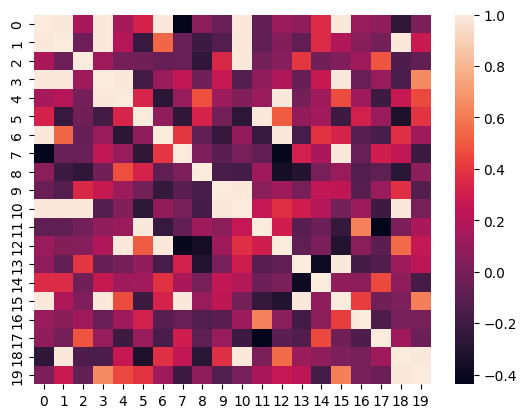

In [92]:
# papers.cov()
sns.heatmap(res+np.eye(n_authors))

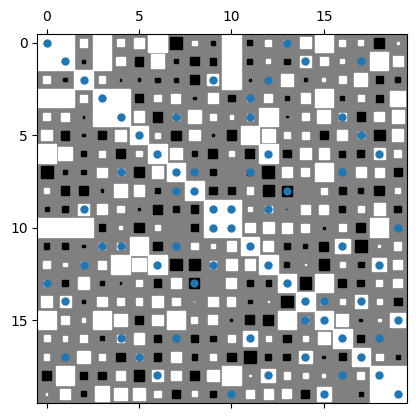

In [95]:
hinton(res+np.eye(n_authors))
plt.spy(L, marker='.')

<AxesSubplot: ylabel='Probability'>

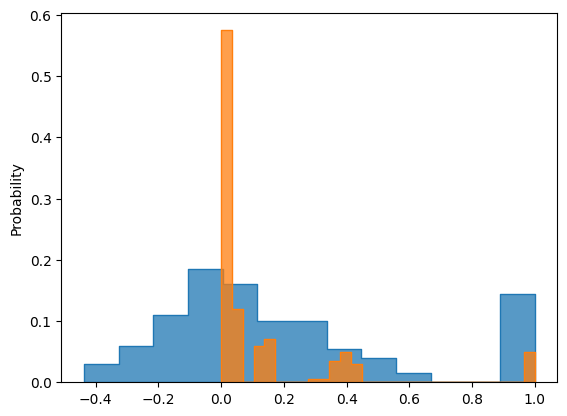

In [89]:
sns.histplot((res+np.eye(n_authors)).flatten(), element='step', fill='false', stat='probability')
sns.histplot(cov.covariance.flatten(), element='step', fill='false', stat='probability')

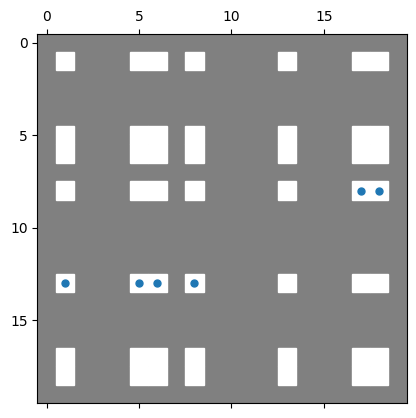

In [21]:
from scipy.sparse.csgraph import minimum_spanning_tree, csgraph_from_dense
from scipy.sparse import coo_array
from scipy.linalg import khatri_rao

def pairwise_interractions(x):
    return np.multiply.outer(x,x)

unrolled = khatri_rao(obs_incidence.unstack().T, obs_incidence.unstack().T).T
unrolled.reshape((100,20,20))[0] == pairwise_interractions(obs_incidence.unstack().iloc[0].sparse.to_dense().values)

hinton(unrolled.reshape((100,20,20))[0])
# plt.spy(L.values, marker='.')
# papers.loc[3]
# 
plt.spy(minimum_spanning_tree(unrolled.reshape((100,20,20))[0]), marker='.')

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
dtype: float64

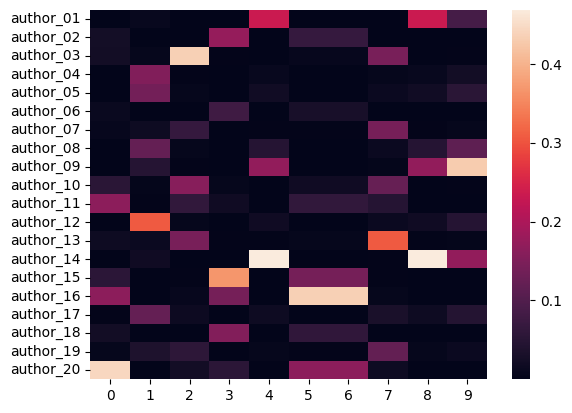

In [22]:
# sns.heatmap((np.diag(np.diag(L)) - L)@obs_incidence.unstack().T)
def forest(L, β=1):
    return pd.DataFrame(np.linalg.inv(np.eye(L.shape[0])+β*L), columns=L.columns, index=L.index)
β=1
sns.heatmap(forest(L,β)@rng.multinomial(1, np.diag(L)/np.diag(L).sum(), size=10).T)
np.sum(forest(L,β)@rng.multinomial(1, np.diag(L)/np.diag(L).sum(), size=10).T, axis=0)

<AxesSubplot: >

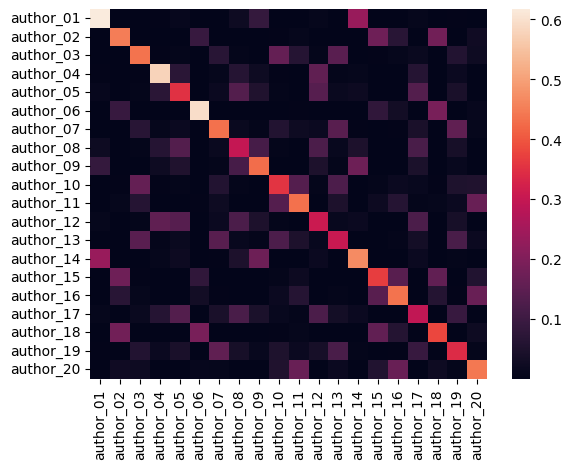

In [23]:
sns.heatmap(forest(L))

<AxesSubplot: >

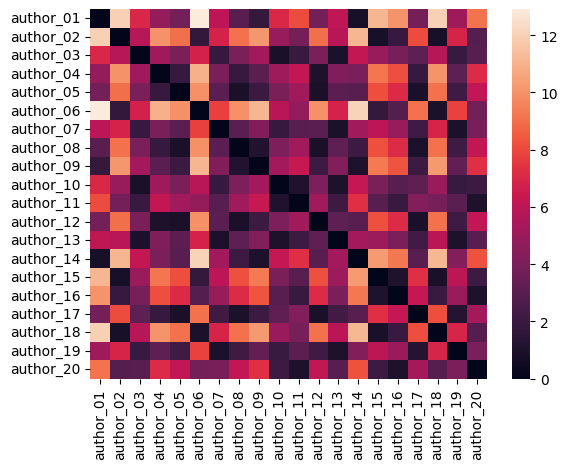

In [24]:
def interp_dist(L, β=1):
    Q = forest(L, β)
    norm = np.sqrt(np.multiply.outer(q_ii:=np.diag(Q), q_ii))
    return -np.log(Q/norm)

sns.heatmap(interp_dist(L, β=1))
    

<AxesSubplot: >

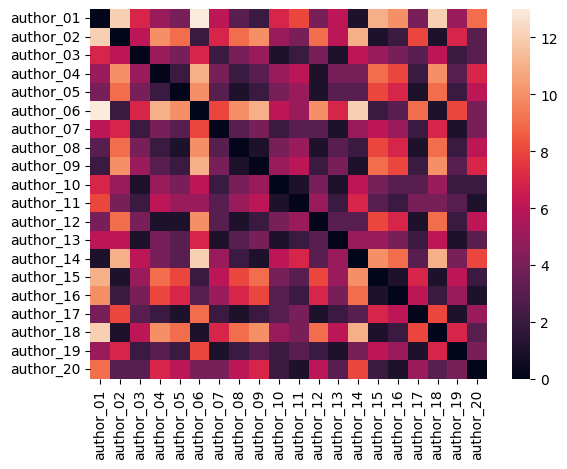

In [25]:
# pd.json_normalize(
sns.heatmap(pd.DataFrame.from_dict({k:v for k,v in nx.all_pairs_shortest_path_length(author_rel)}).sort_index())
# )
# list(nx.all_pairs_shortest_path_length(author_rel))

In [26]:
np.sum(rng.choice(np.eye(n_authors), p=np.diag(L)/np.diag(L).sum(), size=(10,5), replace=True), axis=1)

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 1., 0., 0.,
        1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 2., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        2., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 2., 0.],
       [1., 1., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
        0., 1., 0., 0.]])

<AxesSubplot: >

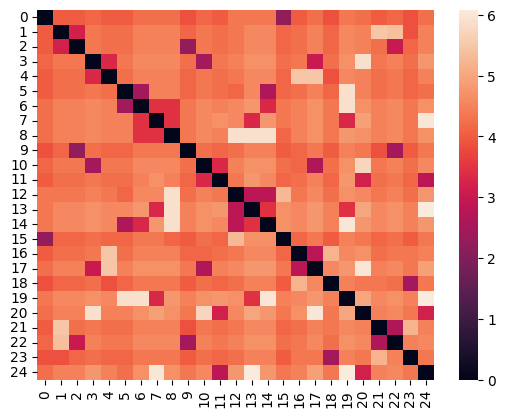

In [27]:
# sns.heatmap(B@(L+np.eye(n_authors))@B.T)
# L[np.triu_indices(n_authors)]

sns.heatmap(squareform(pdist(B, metric='mahalanobis', VI = L+np.eye(n_authors))))
# sns.heatmap(squareform(pdist(B, metric='mahalanobis', VI = L)))

In [28]:
edge_obs=khatri_rao(obs_incidence.unstack(), np.vstack([B]))
# sns.heatmap(np.diag(edge_obs.sum(axis=0))*100 - edge_obs.T@edge_obs)
# edge_obs.shape
(edge_obs.T@edge_obs)/(papers.T@papers)

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author_01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
author_02,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0
author_03,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_04,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_05,0.0,0.0,0.0,0.0,3.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
author_06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
author_07,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
author_08,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,4.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
author_09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
author_10,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from itertools import combinations, permutations

rels_idx = pd.MultiIndex.from_tuples(
    permutations(author_idx, 2), names=['source', 'target']
).to_flat_index()

obs_unrolled=pd.DataFrame(
    unrolled, index=papers.index, 
    columns=pd.MultiIndex.from_product(
        2*[obs_incidence.unstack().T.index], names=['source', 'target']
    )#.to_flat_index()
).loc[:,rels_idx]

obs_unrolled

source author_01                                                              \
target author_02 author_03 author_04 author_05 author_06 author_07 author_08   
week                                                                           
0              0         0         0         0         0         0         0   
1              0         0         0         0         0         0         0   
2              0         0         0         0         0         0         0   
3              0         0         0         0         0         0         0   
4              0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
95             0         0         0         0         0         0         0   
96             0         0         0         0         0         0         0   
97             0         0         0         0         0         0         0   
98             0         0         1         1         0         0         1   
99             0         1         0         0         0         1         0   

source                                ... author_20                      \
target author_09 author_10 author_11  ... author_10 author_11 author_12   
week                                  ...                                 
0              0         0         0  ...         0         0         0   
1              0         0         0  ...         0         1         0   
2              0         0         0  ...         1         0         0   
3              0         0         0  ...         0         0         0   
4              0         0         0  ...         0         0         0   
...          ...       ...       ...  ...       ...       ...       ...   
95             0         0         0  ...         0         0         0   
96             0         0         0  ...         0         0         0   
97             0         0         0  ...         0         0         0   
98             0         0         0  ...         0         0         0   
99             0         1         1  ...         0         0         0   

source                                                                        
target author_13 author_14 author_15 author_16 author_17 author_18 author_19  
week                                                                          
0              0         0         0         0         0         0         0  
1              0         0         1         1         0         1         0  
2              1         0         0         0         0         0         1  
3              0         0         0         0         0         0         0  
4              0         0         0         0         0         0         0  
...          ...       ...       ...       ...       ...       ...       ...  
95             0         0         0         0         0         0         0  
96             0         0         1         0         0         0         0  
97             0         0         0         0         0         0         0  
98             0         0         0         0         0         0         0  
99             0         0         0         0         0         0         0  

[100 rows x 380 columns]

In [31]:
# pd.Series(1,index=pd.MultiIndex.from_product([author_idx, author_idx], names=['source', 'target']).to_flat_index())+pd.Series(1, index=pd.MultiIndex.from_frame(edgelist).to_flat_index())
# incidence
bigB=(
    # B
    # .set_index(pd.MultiIndex.from_frame(edgelist).to_flat_index())
    pd.concat([B.set_index(pd.MultiIndex.from_frame(edgelist).to_flat_index()),
              -B.set_index(pd.MultiIndex.from_frame(edgelist).swaplevel().to_flat_index())
              ]) 
    .reindex(rels_idx)
).fillna(0)
bigB

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
"(author_01, author_02)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_01, author_03)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_01, author_04)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_01, author_05)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_01, author_06)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(author_20, author_15)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_20, author_16)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0
"(author_20, author_17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(author_20, author_18)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
true_est=obs_unrolled@bigB.abs()/2#/bigB.abs().sum()
true_est

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
week,,,,,,,,,,,,,,,,,,,,
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0
2,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0


In [33]:
bigB.abs().sum(), obs_unrolled.sum()

(author_01    2.0
 author_02    4.0
 author_03    4.0
 author_04    2.0
 author_05    6.0
 author_06    2.0
 author_07    4.0
 author_08    8.0
 author_09    4.0
 author_10    6.0
 author_11    4.0
 author_12    8.0
 author_13    8.0
 author_14    4.0
 author_15    6.0
 author_16    4.0
 author_17    8.0
 author_18    6.0
 author_19    6.0
 author_20    4.0
 dtype: float64,
 source     target   
 author_01  author_02     7
            author_03    13
            author_04    15
            author_05    22
            author_06     9
                         ..
 author_20  author_15    19
            author_16    17
            author_17     1
            author_18    15
            author_19     2
 Length: 380, dtype: int64)

In [34]:
bigB.T@bigB

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author_01,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0
author_02,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,-2.0,0.0,0.0
author_03,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_04,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_05,0.0,0.0,0.0,0.0,6.0,0.0,0.0,-2.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0
author_06,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0
author_07,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,-2.0,0.0
author_08,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,8.0,-2.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0
author_09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,4.0,0.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0
author_10,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,-2.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


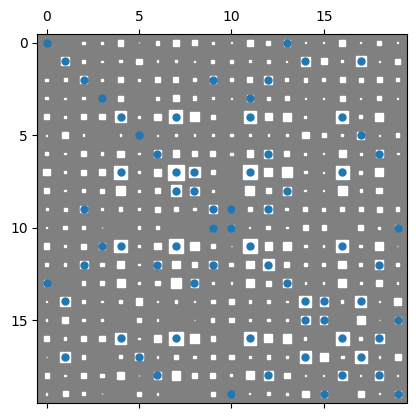

In [35]:
# obs_unrolled
# obs_incidence.unstack().T
# papers
# B#.set_index(pd.MultiIndex.from_frame(edgelist).to_flat_index())
# edgelist
hinton((true_est.T@true_est).values)
plt.spy(L, marker='.')

Text(0.5, 1.05, 'Authors on a paper by week')

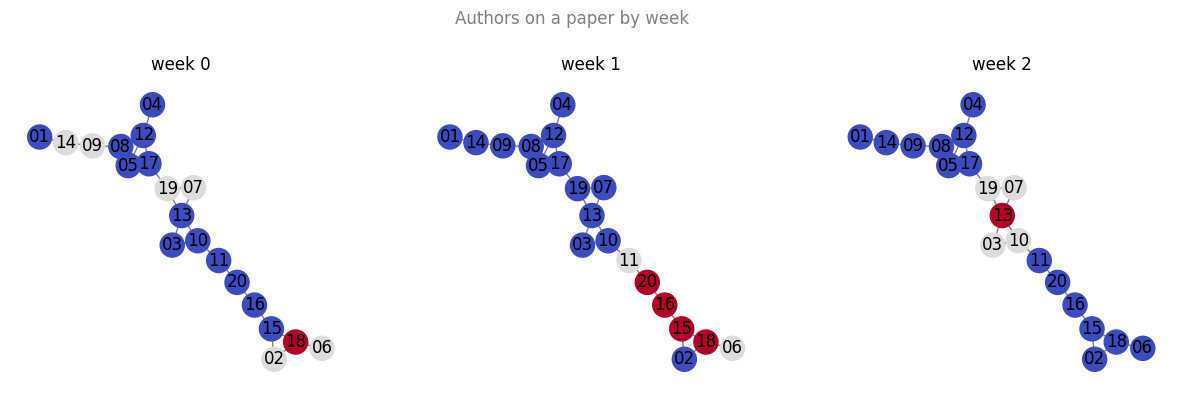

In [36]:
f, axs=plt.subplots(ncols=3, figsize=(15,4)) 

f.patch.set_alpha(0.)
for n,ax in enumerate(axs): 
    nx.draw(author_rel, pos=pos, edge_color='grey',
        node_color=true_est.iloc[n].loc[list(author_rel.nodes)], cmap='coolwarm', ax=ax)
    nx.draw_networkx_labels(author_rel, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in author_rel}, ax=ax)
    ax.set(title=f'week {n}')
# plt.tight_layout()
f.suptitle('Authors on a paper by week', color='grey', y=1.05)

In [37]:
obs_unrolled.iloc[0].unstack()#.set_axis(pd.MultiIndex.from_tuples(obs_unrolled.columns)).unstack().values

target,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
source,,,,,,,,,,,,,,,,,,,,
author_01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_02,0.0,NaN,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
author_03,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_04,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_05,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_06,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
author_07,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
author_08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_09,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [38]:
np.logical_xor.outer(papers.iloc[0].values, papers.iloc[0].values)

array([[False,  True, False, False, False,  True,  True, False,  True,
        False, False, False, False,  True, False, False, False,  True,
         True, False],
       [ True, False,  True,  True,  True, False, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True],
       [False,  True, False, False, False,  True,  True, False,  True,
        False, False, False, False,  True, False, False, False,  True,
         True, False],
       [False,  True, False, False, False,  True,  True, False,  True,
        False, False, False, False,  True, False, False, False,  True,
         True, False],
       [False,  True, False, False, False,  True,  True, False,  True,
        False, False, False, False,  True, False, False, False,  True,
         True, False],
       [ True, False,  True,  True,  True, False, False,  True, False,
         True,  True,  True,  True, False,  True,  True,  True, False,
        False,  True],
       [ T

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,...,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20,meta
author_01,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472
author_02,0.000000,0.067416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.022472,0.000000,0.000000,-0.022472,0.000000,0.000000,-0.022472
author_03,0.000000,0.000000,0.067416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472,...,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472
author_04,0.000000,0.000000,0.000000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472
author_05,0.000000,0.000000,0.000000,0.000000,0.089888,0.000000,0.000000,-0.022472,0.000000,0.000000,...,-0.022472,0.000000,0.000000,0.000000,0.000000,-0.022472,0.000000,0.000000,0.000000,-0.022472
author_06,0.000000,0.000000,0.000000,0.000000,0.000000,0.044944,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472,0.000000,0.000000,-0.022472
author_07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067416,0.000000,0.000000,0.000000,...,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472,0.000000,-0.022472
author_08,0.000000,0.000000,0.000000,0.000000,-0.022472,0.000000,0.000000,0.112360,-0.022472,0.000000,...,-0.022472,0.000000,0.000000,0.000000,0.000000,-0.022472,0.000000,0.000000,0.000000,-0.022472
author_09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472,0.067416,0.000000,...,0.000000,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472
author_10,0.000000,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089888,...,0.000000,-0.022472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022472


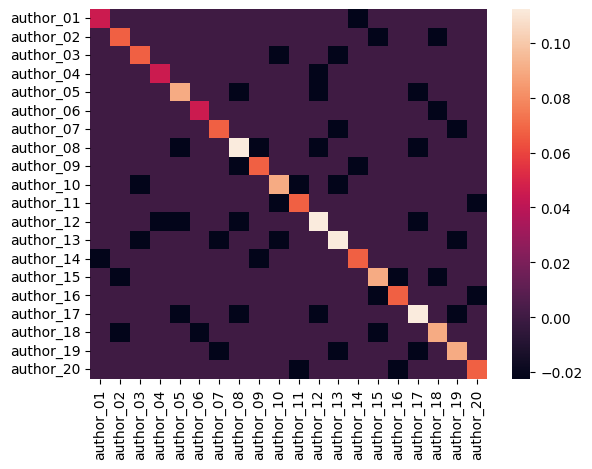

In [39]:
B_meta = pd.concat(
    [B, -B, eyeDF:=pd.DataFrame(np.eye(B.shape[1]), columns=B.columns), -eyeDF]
).assign(meta=np.hstack((
    np.zeros(B.shape[0]), np.zeros(B.shape[0]),
    -np.ones(B.shape[1]),
     np.ones(B.shape[1])
)))

sns.heatmap(B_meta.cov().drop(columns='meta', index='meta'))
B_meta.cov()

<AxesSubplot: >

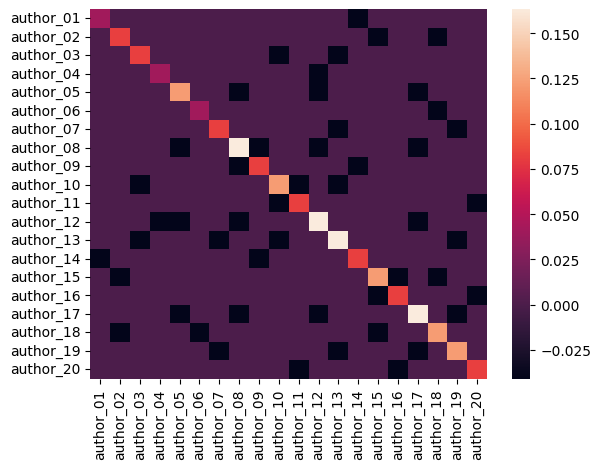

In [40]:
sns.heatmap(pd.concat([B, -B]).cov())

# B_meta.cov()/pd.concat([B, -B]).cov()

<AxesSubplot: >

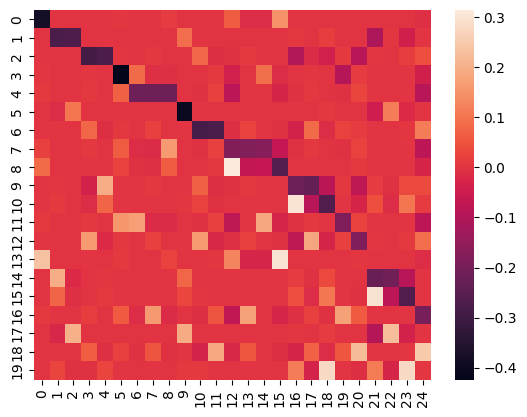

In [41]:
sns.heatmap(np.linalg.inv(L+np.eye(n_authors))@B.T)

In [148]:
# pd.Series(1, index=pd.MultiIndex.from_arrays([Qi.index[np.minimum(Ti.row, Ti.col)], Qi.index[np.maximum(Ti.row, Ti.col)]]))

In [442]:
from itertools import chain
from toolz import sliding_window
Q = pd.DataFrame(interp_dist(L),columns=L.columns, index=L.index)
Ti = minimum_spanning_tree(-np.log(Qi:=Q.loc[papers.astype(bool).iloc[0], papers.astype(bool).iloc[0]])).tocoo()
(Qi*Ti.todense()).unstack()


def estimate_mst_basis(x, dist:pd.DataFrame):
    # A_x = A.loc[x, x]
    D_x = dist.loc[x, x]
    T_stein = minimum_spanning_tree(-np.log(D_x)).tocoo()
    src,tgt = (D_x.index[np.minimum(T_stein.row, T_stein.col)], 
               D_x.index[np.maximum(T_stein.row, T_stein.col)])
    yield from zip(src,tgt)
    # return pd.Series(1, index=pd.MultiIndex.from_arrays(
    #     [src, tgt], names=['source','target']), dtype='Sparse[int]', name='weight')

def stein_edge_approx(paths, edges, holdout='meta'): 
    for u,v in edges: 
        yield from (sorted(pair) for pair in sliding_window(2, paths[u][v])) 
# def estimate_basis(x, paths=None, dist=None, holdout=Meta):
#     return pd.Series(1, index=pd.MultiIndex.from_tuples(
#         stein_edge_approx(paths, estimate_stein_basis(x, dist), names=['source','target']), dtype='Sparse[int]', name='weight')
        
# L_samp = 2*np.diag(papers.sum())-papers.T@papers
A_samp =  ((papers.T@papers) - np.diag(papers.sum()))
L_samp = np.diag(A_samp.sum()) - A_samp
# L_samp


list(estimate_mst_basis(papers.astype(bool).iloc[0], dist=interp_dist(L_samp, β=1)))
β=10
obs_edges=list(chain(*[estimate_stein_basis(x[1].values, dist=interp_dist(L_samp, β=β)) for x in papers.astype(bool).iterrows()]))

/home/tbsexton/.pyenv/versions/notebooks/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [443]:
A_samp.values.mean()

9.19

In [444]:
Ahat = A_samp.assign(meta=β).T.assign(meta=n_authors*[β]+[0])
# 1./Ahat
# sns.heatmap(np.log(Ahat))
1/Ahat

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,...,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20,meta
author,,,,,,,,,,,,,,,,,,,,,
author_01,inf,0.166667,0.142857,0.066667,0.066667,0.111111,0.100000,0.071429,0.050000,0.142857,...,0.076923,0.166667,0.045455,0.250000,0.333333,0.071429,0.125000,0.166667,0.166667,0.1
author_02,0.166667,inf,0.142857,0.083333,0.200000,0.027778,0.250000,0.200000,0.333333,0.200000,...,0.142857,0.500000,0.333333,0.030303,0.040000,0.333333,0.027778,0.500000,0.035714,0.1
author_03,0.142857,0.142857,inf,0.166667,0.125000,0.125000,0.100000,0.500000,0.200000,0.100000,...,0.250000,0.083333,0.250000,0.166667,0.142857,0.111111,0.200000,0.090909,0.083333,0.1
author_04,0.066667,0.083333,0.166667,inf,0.041667,0.076923,0.100000,0.047619,0.058824,0.166667,...,0.040000,0.111111,0.083333,0.111111,0.250000,0.050000,0.100000,0.111111,0.100000,0.1
author_05,0.066667,0.200000,0.125000,0.041667,inf,0.142857,0.142857,0.058824,0.062500,0.125000,...,0.043478,0.125000,0.083333,0.166667,inf,0.047619,0.250000,0.111111,0.250000,0.1
author_06,0.111111,0.027778,0.125000,0.076923,0.142857,inf,0.166667,0.142857,0.333333,0.166667,...,0.166667,1.000000,0.250000,0.031250,0.041667,0.250000,0.027027,0.500000,0.037037,0.1
author_07,0.100000,0.250000,0.100000,0.100000,0.142857,0.166667,inf,0.166667,0.142857,0.111111,...,0.166667,0.062500,0.125000,0.200000,0.166667,0.125000,0.250000,0.083333,0.166667,0.1
author_08,0.071429,0.200000,0.500000,0.047619,0.058824,0.142857,0.166667,inf,0.062500,1.000000,...,0.050000,0.250000,0.076923,0.166667,1.000000,0.062500,0.166667,0.166667,0.250000,0.1
author_09,0.050000,0.333333,0.200000,0.058824,0.062500,0.333333,0.142857,0.062500,inf,0.333333,...,0.071429,0.200000,0.050000,0.500000,1.000000,0.066667,0.333333,0.200000,0.500000,0.1


In [445]:
# dict(nx.all_pairs_shortest_path())
paths=dict(nx.all_pairs_dijkstra_path(nx.from_pandas_adjacency(Ahat), weight=lambda u,v,d: 1./d['weight']))
# nx.dijkstra_path(
# paths

In [452]:
A_est = pd.DataFrame(list(stein_edge_approx(paths, obs_edges)), columns=['source', 'target']).assign(weight=1).groupby(['source', 'target']).sum()#.unstack()['weight'].fillna(0)
# A_est = np.maximum(A_est, A_est.T).fillna(0)
# hinton(A_est.fillna(0).values)
# plt.spy(L, marker='.')
# sns.heatmap(A_est)
A_est.sort_index()#.reset_index()
(papers.T@papers - np.diag(papers.sum())).astype('Sparse[int]').sparse.

author,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author,,,,,,,,,,,,,,,,,,,,
author_01,0,6,7,15,15,9,10,14,20,7,7,13,6,22,4,3,14,8,6,6
author_02,6,0,7,12,5,36,4,5,3,5,15,7,2,3,33,25,3,36,2,28
author_03,7,7,0,6,8,8,10,2,5,10,11,4,12,4,6,7,9,5,11,12
author_04,15,12,6,0,24,13,10,21,17,6,11,25,9,12,9,4,20,10,9,10
author_05,15,5,8,24,0,7,7,17,16,8,6,23,8,12,6,0,21,4,9,4
author_06,9,36,8,13,7,0,6,7,3,6,14,6,1,4,32,24,4,37,2,27
author_07,10,4,10,10,7,6,0,6,7,9,9,6,16,8,5,6,8,4,12,6
author_08,14,5,2,21,17,7,6,0,16,1,4,20,4,13,6,1,16,6,6,4
author_09,20,3,5,17,16,3,7,16,0,3,3,14,5,20,2,1,15,3,5,2


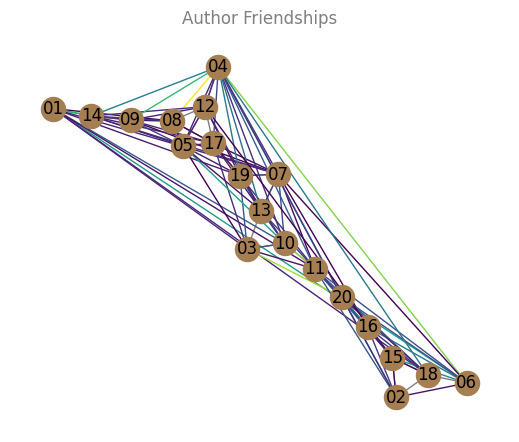

In [320]:
f = plt.figure(figsize=(5,4)).patch.set_alpha(0.)
pos=nx.layout.kamada_kawai_layout(author_rel)
nx.draw(author_rel, pos=pos, 
        node_color='xkcd:puce', edge_color='grey')
nx.draw_networkx_labels(author_rel, pos=pos, font_color='k',labels={n:n.split('_')[-1] for n in author_rel})
plt.title('Author Friendships', color='grey')
G_est=nx.from_pandas_edgelist(A_est.reset_index(), edge_attr='weight')
G_est.remove_node('meta')
nx.draw_networkx_edges(G_est, pos=pos, edge_color=[G_est[u][v]['weight'] for u,v in G_est.edges])
# [G_est.get_edge_data(u,v) for u,v in G_est.edges]

In [259]:
# basis_sum = pd.concat(list(estimate_basis(x[1].values, dist=interp_dist(L_samp, β=10)) 
#                for x in papers.astype(bool).iterrows()),
#           axis=1).T.sum().sort_index().astype('Sparse[int]')
# # nx.from_pandas_edgelist(basis_sum)
# Ghat = nx.from_pandas_edgelist(basis_sum.reset_index(name='weight'))
# # pd.concat[x for x in papers.astype(bool).iterrows()]
# sns.heatmap(np.maximum(Ghatmat:=basis_sum.sparse.to_coo()[0].todense(), Ghatmat.T))

<AxesSubplot: >

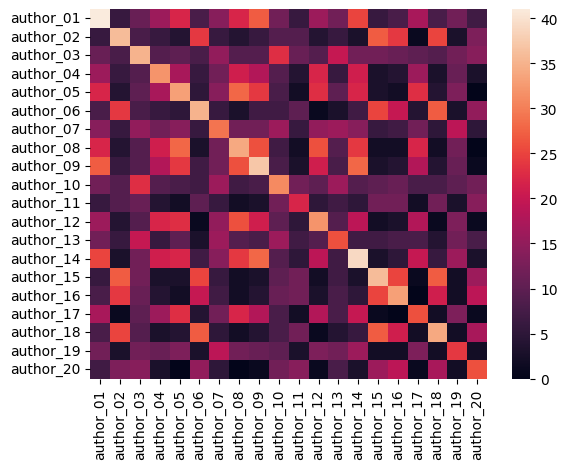

In [45]:
sns.heatmap(papers.T@papers)

In [115]:
np.maximum(basis_sum.unstack(), basis_sum.unstack().T.assign(author_01=np.nan).T)

/tmp/ipykernel_2123755/923364516.py:1: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.maximum(basis_sum.unstack().T.assign(author_01=np.nan), basis_sum.unstack().T.assign(author_01=np.nan).T)


ValueError: operands could not be broadcast together with shapes (19,18) (18,19) 

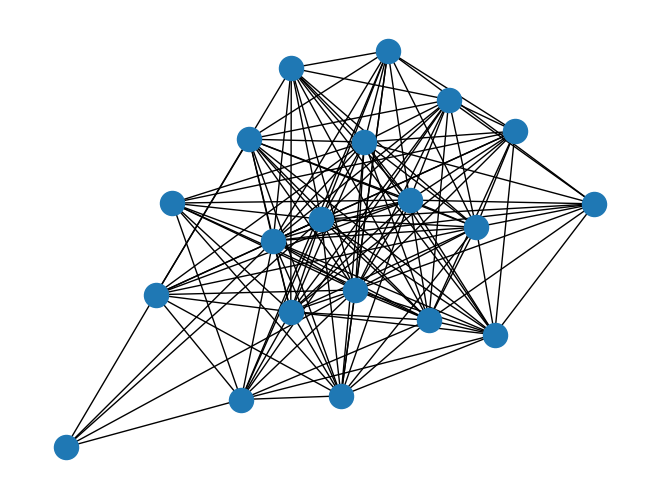

In [101]:
nx.draw_networkx(Ghat, width=Ghat.edges.data['weight'])

In [224]:
L_samp = ((papers.T@papers) - np.diag(papers.sum()))
L_samp = np.diag(L_samp.sum()) - L_samp
L_samp

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author_01,106,-3,-5,-8,-11,-4,-5,-10,-12,-4,-2,-7,-5,-11,-2,-2,-7,-3,-5,0
author_02,-3,107,-5,-2,-4,-13,-5,-1,-3,-5,-5,-1,-5,-1,-16,-14,-1,-14,-2,-7
author_03,-5,-5,117,-7,-5,-6,-8,-5,-5,-13,-4,-6,-9,-6,-6,-6,-5,-4,-6,-6
author_04,-8,-2,-7,123,-10,-5,-8,-11,-9,-6,-4,-12,-4,-12,-2,-2,-10,-3,-6,-2
author_05,-11,-4,-5,-10,129,-5,-7,-15,-12,-4,-2,-12,-5,-11,-3,-1,-12,-4,-6,0
author_06,-4,-13,-6,-5,-5,120,-5,-3,-5,-4,-5,-1,-3,-5,-15,-12,-3,-16,-1,-9
author_07,-5,-5,-8,-8,-7,-5,118,-6,-4,-8,-4,-9,-9,-7,-4,-4,-6,-5,-11,-3
author_08,-10,-1,-5,-11,-15,-3,-6,124,-13,-4,-2,-14,-5,-13,-1,-1,-12,-2,-6,0
author_09,-12,-3,-5,-9,-12,-5,-4,-13,119,-3,-3,-10,-3,-16,-2,-2,-9,-3,-5,0
author_10,-4,-5,-13,-6,-4,-4,-8,-4,-3,103,-5,-6,-8,-4,-5,-5,-4,-4,-6,-5


### TODO

Stop here...

<AxesSubplot: >

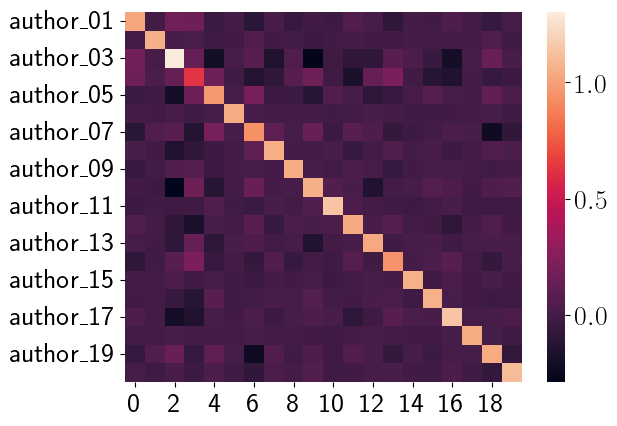

In [587]:
sns.heatmap((papers.T@papers-np.diag(papers.sum()))@np.linalg.inv(np.eye(n_authors)+(papers.T@papers-np.diag(papers.sum()))))

,author_01,author_02,author_03,author_04,author_05,author_06,author_07,author_08,author_09,author_10,author_11,author_12,author_13,author_14,author_15,author_16,author_17,author_18,author_19,author_20
author_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
author_10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


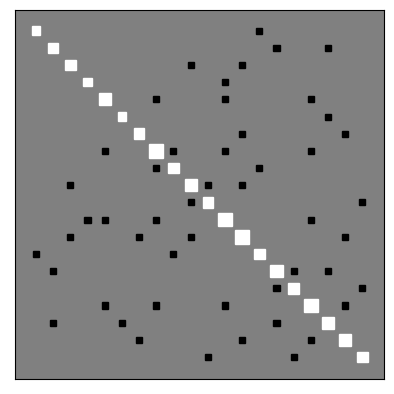

In [588]:
# plt.imshow((B.assign(lin=1)@np.linalg.pinv(B.assign(lin=1))))
# np.linalg.inv(L+np.eye(n_authors))
# plt.spy(sparse.coo_array(L.values), marker='.', color='w')
# hinton(L.values, ax=ax)
Bmod = np.vstack([B.values, 0.5*np.sqrt(2)*np.eye(n_authors), -0.5*np.sqrt(2)*np.eye(n_authors)])
hinton((Bmod.T@Bmod))
# plt.spy(L+np.eye(n_authors), marker='.')
(Bmod.T@Bmod) - np.eye(n_authors)-L

In [589]:
D_inv=np.diag(1./np.sqrt(np.diag(L)))
cal_L=D_inv@L@D_inv

Σ = stats.Covariance.from_precision(L+1*np.eye(n_authors))

# Σ = stats.Covariance.from_precision(Ls)

sns.heatmap(Σ.covariance)

AttributeError: module 'scipy.stats' has no attribute 'Covariance'

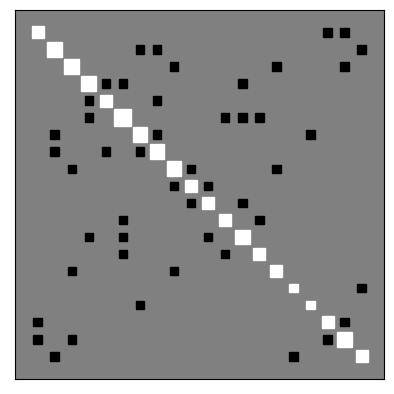

In [39]:
hinton(L.values)

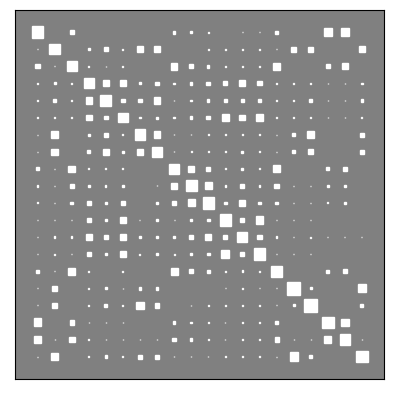

In [316]:
hinton(Σ.covariance)

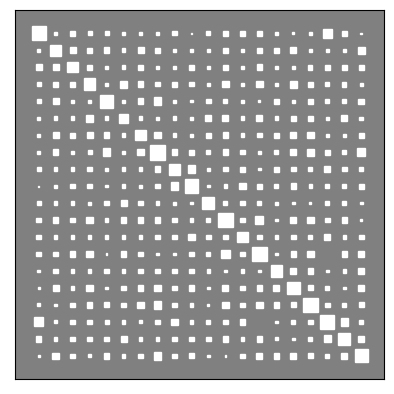

In [54]:
papers = pd.DataFrame(
    np.where(stats.multivariate_normal(cov=Σ, seed=rng).rvs(200)>1, 1,0),
    columns=author_idx
).rename_axis('week')
hinton(papers.cov().values-papers.cov().values.min())
# papers.cov()

In [22]:
Σ.covariance.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [23]:
pd.DataFrame(
    np.where(stats.multivariate_normal(cov=Σ, seed=rng).rvs(200)>1, 1,0),
    columns=author_idx
).rename_axis('week').sum(axis=1)

# eps=0.01*np.eye(n_authors)

# sns.heatmap(sparse.linalg.inv(sparse.csc_array(L+eps)).todense())

week
0      2
1      4
2      2
3      1
4      1
      ..
195    0
196    2
197    3
198    1
199    1
Length: 200, dtype: int64

In [176]:
# Create sparse, symmetric PSD matrix S
A = rng.standard_normal(size=(n_authors, n_authors))  # Unit normal gaussian distribution.
A[sparse.rand(n_authors, n_authors, 0.85).todense().nonzero()] = 0  # Sparsen the matrix.
Strue = A.dot(A.T) + 0.05 * np.eye(n_authors)  # Force strict pos. def.

# Create the covariance matrix associated with S.
R = np.linalg.inv(Strue)

# Create samples y_i from the distribution with covariance R.
y_sample = linalg.sqrtm(R).dot(rng.standard_normal((n_authors, 30)))

# Calculate the sample covariance matrix.
Y = np.cov(y_sample)

<AxesSubplot: >

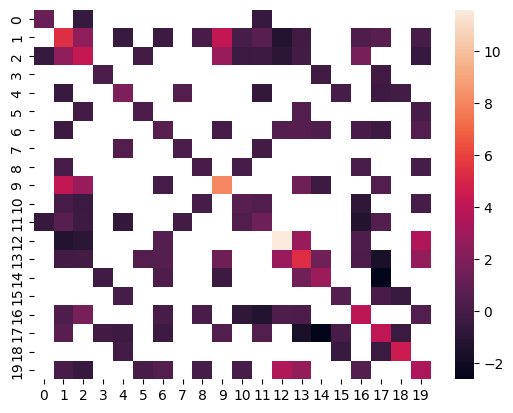

In [183]:
sns.heatmap(Strue, mask=Strue==0)

<AxesSubplot: >

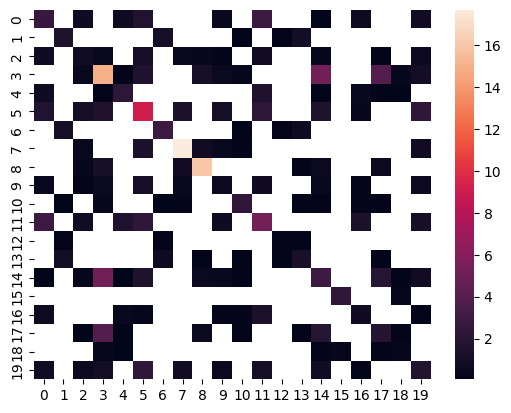

In [192]:
sns.heatmap(R, mask=R<=0.05)

<AxesSubplot: >

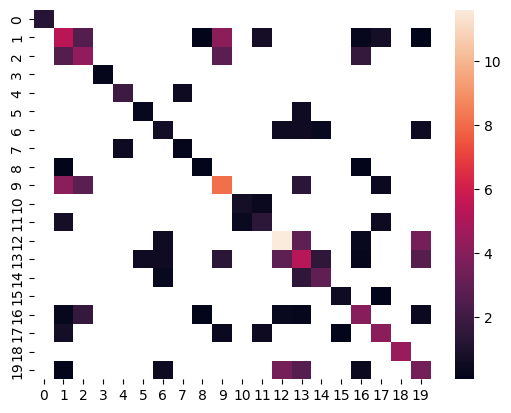

In [200]:
sns.heatmap(np.linalg.inv(R), mask=np.linalg.inv(R)<=0.05)

<AxesSubplot: >

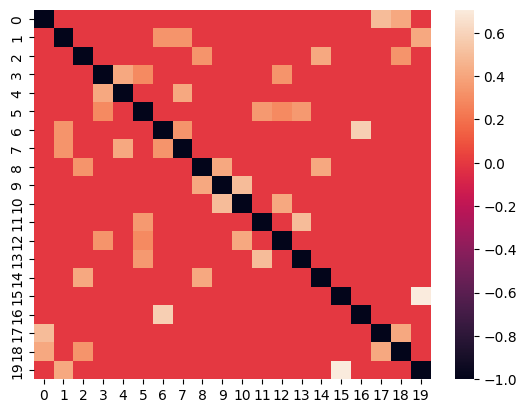

In [314]:
## Using covariance
p = np.cov(np.vstack([
    B, 
    -B, 
    # Ir2 := np.sqrt(2)*np.eye(n_authors)/2., 
    # -Ir2
]).T)
dp = np.sqrt(np.diag(p))
par_corr = -p/(np.outer(dp, np.ones_like(dp))*np.outer(np.ones_like(dp), dp))
sns.heatmap(par_corr)


## Using inner-product
# p = np.linalg.inv(L+np.eye(n_authors))
# dp = np.sqrt(np.diag(p))
# par_corr = p/(np.outer(dp, np.ones_like(dp))*np.outer(np.ones_like(dp), dp))
# sns.heatmap(par_corr)

<AxesSubplot: >

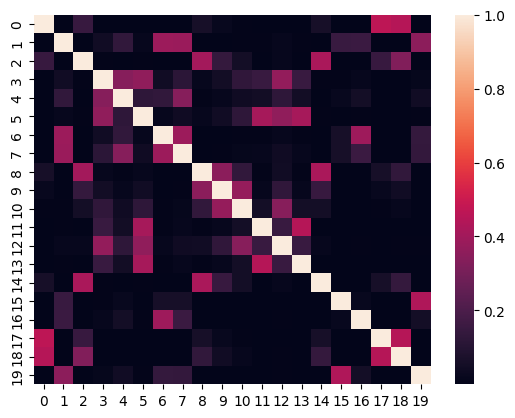

<AxesSubplot: >

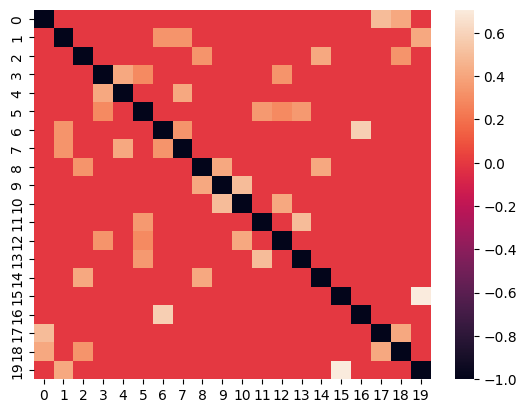

In [303]:
D_inv=linalg.sqrtm(np.diag(1./np.diag(p)))
cal_p=D_inv@p@D_inv
sns.heatmap(-cal_p)

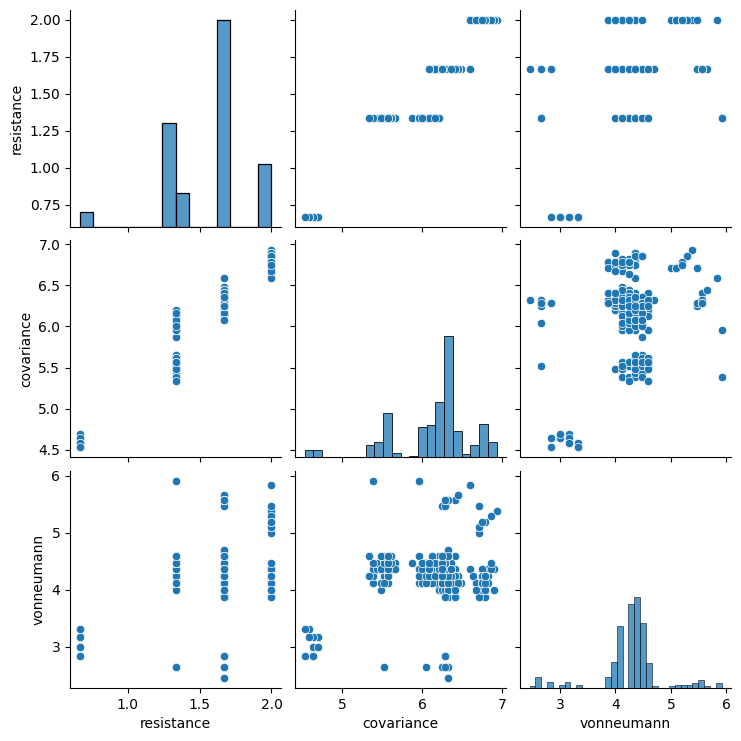

In [308]:
from scipy.spatial.distance import pdist, cdist, squareform
sns.pairplot(pd.DataFrame(dict(
    resistance=pdist(B, metric='mahalanobis', VI=np.linalg.pinv(L))**2,
    covariance=pdist(B, metric='mahalanobis'),
    vonneumann=pdist(B, metric='mahalanobis', VI=L+np.eye(n_authors)),
)), )


# B.values@np.linalg.pinv(L)@B.T

<AxesSubplot: >

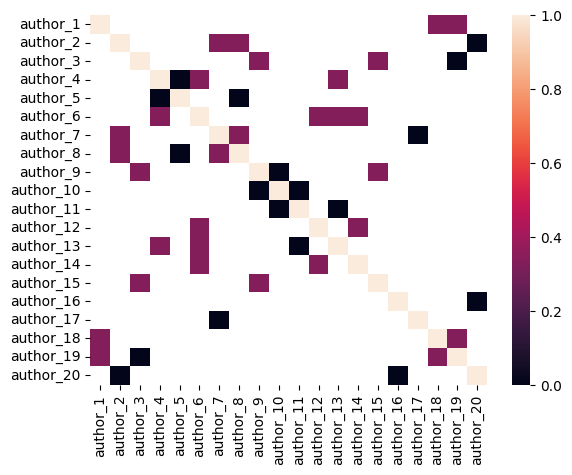

In [309]:
sns.heatmap(pd.DataFrame(1-squareform(pdist(np.eye(n_authors), metric='mahalanobis', VI=np.linalg.pinv(L))**2),
                        columns=author_idx, index=author_idx),mask=(L==0).values)

<AxesSubplot: >

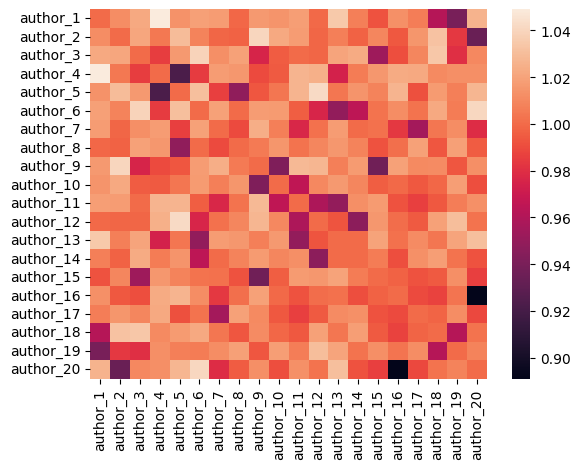

In [312]:
sns.heatmap(1-
    (papers.cov() - np.diag(np.diag(papers.cov())))*(
        squareform(pdist(np.eye(n_authors), metric='mahalanobis', 
                         VI=np.linalg.pinv(papers.cov() + np.eye(n_authors))
                        )**2
                  )
    ), mask=(papers.cov().values==0)
)